In [25]:
%matplotlib inline

In [26]:
import os
import shutil
import random
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

In [27]:
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [14]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [16]:
tf.__version__ # Install tensorflow-gpu==2.0.0, if it can utilize CUDA

'2.4.0-rc1'

In [31]:
def show_image(img, grayscale=False, file=None):
    plt.figure(figsize=(12,8))
    ax = plt.subplot(111)
    if grayscale:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)        
    else:
        plt.imshow(img)
    plt.xticks([]),plt.yticks([])
    ax.axis("off")
    plt.tight_layout()
    
    if file:
        plt.savefig('../../data/temp/{}.png'.format(file))
    
    plt.show()

In [6]:
base_model = InceptionV3(
    input_shape = (160, 160, 3), 
    include_top = False, 
    weights = 'imagenet'
)

In [1]:
#base_model.summary()

In [7]:
for layer in base_model.layers:
    layer.trainable = False
base_model.trainable = False

In [8]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
#model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 600, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 399, 299, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 399, 299, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 399, 299, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

model = tf.keras.Sequential([
    layers.Flatten()(base_model.output),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
y = model(base_model.input)

In [ ]:
model.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

In [16]:
def createTrainTestData(perc=0.8):
    files = []
    for filename in os.listdir('../../data/raw/'):
        files.append(filename)
    random.shuffle(files)
    items = int(len(files)*perc)
    train = files[:items]
    test = files[items:]
    print(len(files), '--->', len(train), len(test))
    
    for f in train:
        shutil.copyfile('../../data/raw/{}'.format(f), '../../data/train/{}'.format(f))
    
    for f in test:
        shutil.copyfile('../../data/raw/{}'.format(f), '../../data/test/{}'.format(f))
        
    print("Finished train-test split, using", perc, '% train and', round(1-perc), 'test.')

In [17]:
#createTrainTestData()

1961 ---> 1568 393
Finished train-test split, using 0.8 % train and 0.19999999999999996 test.


In [35]:
train = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test = ImageDataGenerator( rescale = 1.0/255. )

In [36]:
train_gen = train.flow_from_directory(
    "../../data/train/", color_mode="rgb", batch_size = 20, class_mode="categorical", target_size = (150, 150)
)
test_gen = test.flow_from_directory(
    "../../data/test/", color_mode="rgb", batch_size = 20, class_mode="categorical", target_size = (150, 150)
)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [9]:
# Load saved model and build the detection function
print("Load MDL!")
PATH_TO_SAVED_MODEL = r'E:\Cloud\GIT\CVEET\model\faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8\saved_model'
start_time = time.time()
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Load MDL!
Done! Took 135.92519354820251 seconds


In [18]:
category_index = label_map_util.create_category_index_from_labelmap(r'E:\Cloud\GIT\CVEET\model\faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8\labels\mscoco_label_map.pbtxt', use_display_name=True)

In [20]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [21]:
image_np = load_image_into_numpy_array(r'E:\Cloud\GIT\CVEET\data\train\e6_nostvet_11-01-15-13.jpg')

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

<ipython-input-21-032a8140413d>:45: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


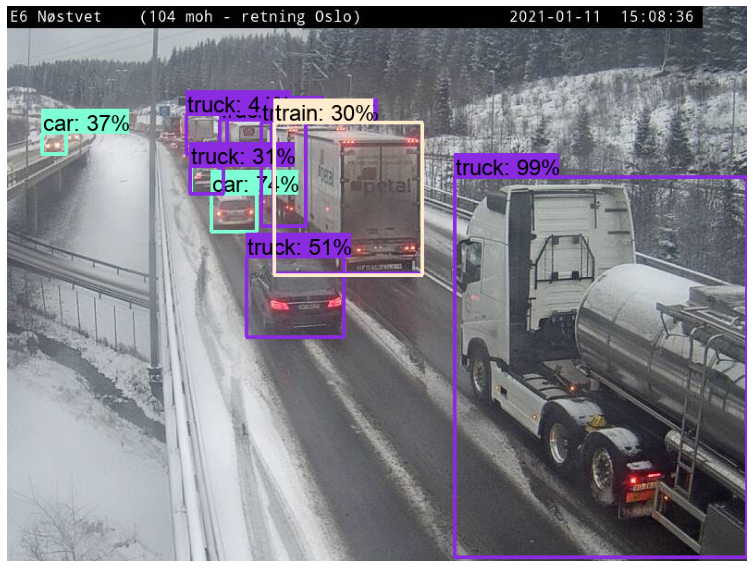

In [34]:
show_image(image_np_with_detections, False, 'out')